# Assignment: Dyna-Q and Dyna-Q+

Welcome to this programming assignment! In this notebook, you will:
1. implement the Dyna-Q and Dyna-Q+ algorithms. 
2. compare their performance on an environment which changes to become 'better' than it was before, that is, the task becomes easier. 

We will give you the environment and infrastructure to run the experiment and visualize the performance. The assignment will be graded automatically by comparing the behavior of your agent to our implementations of the algorithms. The random seed will be set explicitly to avoid different behaviors due to randomness. 

Please go through the cells in order. 

## The Shortcut Maze Environment

In this maze environment, the goal is to reach the goal state (G) as fast as possible from the starting state (S). There are four actions â€“ up, down, right, left â€“ which take the agent deterministically from a state to the corresponding neighboring states, except when movement is blocked by a wall (denoted by grey) or the edge of the maze, in which case the agent remains where it is. The reward is +1 on reaching the goal state, 0 otherwise. On reaching the goal state G, the agent returns to the start state S to being a new episode. This is a discounted, episodic task with $\gamma = 0.95$.

<img src="./images/shortcut_env.png" alt="environment" width="400"/>

Later in the assignment, we will use a variant of this maze in which a 'shortcut' opens up after a certain number of timesteps. We will test if the the Dyna-Q and Dyna-Q+ agents are able to find the newly-opened shorter route to the goal state.

## Packages

We import the following libraries that are required for this assignment. Primarily, we shall be using the following libraries:
1. numpy: the fundamental package for scientific computing with Python.
2. matplotlib: the library for plotting graphs in Python.
3. RL-Glue: the library for reinforcement learning experiments.

**Please do not import other libraries** as this will break the autograder.

In [122]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import jdc
import os
from tqdm import tqdm

from rl_glue import RLGlue
from agent import BaseAgent
from maze_env import ShortcutMazeEnvironment

In [123]:
plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'figure.figsize': [8,5]})

## Section 1: Dyna-Q

Let's start with a quick recap of the tabular Dyna-Q algorithm.

<div style="width:80%"><img src="./images/DynaQ.png" alt="DynaQ_pseudocode"></div>

Dyna-Q involves four basic steps:
1. Action selection: given an observation, select an action to be performed (here, using the $\epsilon$-greedy method).
2. Direct RL: using the observed next state and reward, update the action values (here, using one-step tabular Q-learning).
3. Model learning: using the observed next state and reward, update the model (here, updating a table as the environment is assumed to be deterministic).
4. Planning: update the action values by generating $n$ simulated experiences using certain starting states and actions (here, using the random-sample one-step tabular Q-planning method). This is also known as the 'Indirect RL' step. The process of choosing the state and action to simulate an experience with is known as 'search control'.

Steps 1 and 2 are parts of the [tabular Q-learning algorithm](http://www.incompleteideas.net/book/RLbook2018.pdf#page=153) and are denoted by line numbers (a)â€“(d) in the pseudocode above. Step 3 is performed in line (e), and Step 4 in the block of lines (f).

We highly recommend revising the Dyna videos in the course and the material in the RL textbook (in particular, [Section 8.2](http://www.incompleteideas.net/book/RLbook2018.pdf#page=183)).

Alright, let's begin coding.

As you already know by now, you will develop an agent which interacts with the given environment via RL-Glue. More specifically, you will implement the usual methods `agent_start`, `agent_step`, and `agent_end` in your `DynaQAgent` class, along with a couple of helper methods specific to Dyna-Q, namely `update_model` and `planning_step`. We will provide detailed comments in each method describing what your code should do. 

Let's break this down in pieces and do it one-by-one.

First of all, check out the `agent_init` method below. As in earlier assignments, some of the attributes are initialized with the data passed inside `agent_info`. In particular, pay attention to the attributes which are new to `DynaQAgent`, since you shall be using them later. 

In [124]:
# ---------------
# Discussion Cell
# ---------------

class DynaQAgent(BaseAgent):

    def agent_init(self, agent_info):
        """Setup for the agent called when the experiment first starts.

        Args:
            agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
            {
                num_states (int): The number of states,
                num_actions (int): The number of actions,
                epsilon (float): The parameter for epsilon-greedy exploration,
                step_size (float): The step-size,
                discount (float): The discount factor,
                planning_steps (int): The number of planning steps per environmental interaction

                random_seed (int): the seed for the RNG used in epsilon-greedy
                planning_random_seed (int): the seed for the RNG used in the planner
            }
        """

        # First, we get the relevant information from agent_info 
        # NOTE: we use np.random.RandomState(seed) to set the two different RNGs
        # for the planner and the rest of the code
        try:
            self.num_states = agent_info["num_states"]
            self.num_actions = agent_info["num_actions"]
        except:
            print("You need to pass both 'num_states' and 'num_actions' \
                   in agent_info to initialize the action-value table")
        self.gamma = agent_info.get("discount", 0.95)
        self.step_size = agent_info.get("step_size", 0.1)
        self.epsilon = agent_info.get("epsilon", 0.1)
        self.planning_steps = agent_info.get("planning_steps", 10)

        self.rand_generator = np.random.RandomState(agent_info.get('random_seed', 42))
        self.planning_rand_generator = np.random.RandomState(agent_info.get('planning_random_seed', 42))

        # Next, we initialize the attributes required by the agent, e.g., q_values, model, etc.
        # A simple way to implement the model is to have a dictionary of dictionaries, 
        #        mapping each state to a dictionary which maps actions to (reward, next state) tuples.
        self.q_values = np.zeros((self.num_states, self.num_actions))
        self.actions = list(range(self.num_actions))
        self.past_action = -1
        self.past_state = -1
        self.model = {} # model is a dictionary of dictionaries, which maps states to actions to 
                        # (reward, next_state) tuples

Now let's create the `update_model` method, which performs the 'Model Update' step in the pseudocode. It takes a `(s, a, s', r)` tuple and stores the next state and reward corresponding to a state-action pair.

Remember, because the environment is deterministic, an easy way to implement the model is to have a dictionary of encountered states, each mapping to a dictionary of actions taken in those states, which in turn maps to a tuple of next state and reward. In this way, the model can be easily accessed by `model[s][a]`, which would return the `(s', r)` tuple.

In [125]:
%%add_to DynaQAgent

# -----------
# Graded Cell
# -----------

def update_model(self, past_state, past_action, state, reward):
    """updates the model 
    
    Args:
        past_state       (int): s
        past_action      (int): a
        state            (int): s'
        reward           (int): r
    Returns:
        Nothing
    """
    # Update the model with the (s,a,s',r) tuple (1~4 lines)
    
    # ----------------
    # your code here
    if past_state in self.model:
        self.model[past_state][past_action] = (state, reward)
    else:
        self.model[past_state] = {past_action: (state, reward)}
    # ----------------

### Test `update_model()`

In [126]:
# -----------
# Tested Cell
# -----------
# The contents of the cell will be tested by the autograder.
# If they do not pass here, they will not pass there.

actions = []
agent_info = {"num_actions": 4, 
              "num_states": 3, 
              "epsilon": 0.1, 
              "step_size": 0.1, 
              "discount": 1.0, 
              "random_seed": 0,
              "planning_random_seed": 0}

agent = DynaQAgent()
agent.agent_init(agent_info)

# (past_state, past_action, state, reward)
agent.update_model(0,2,0,1)
agent.update_model(2,0,1,1)
agent.update_model(0,3,1,2)

expected_model = {
    # action 2 in state 0 leads back to state 0 with a reward of 1
    # or taking action 3 leads to state 1 with reward of 2
    0: {
        2: (0, 1),
        3: (1, 2),
    },
    # taking action 0 in state 2 leads to state 1 with a reward of 1
    2: {
        0: (1, 1),
    },
}

assert agent.model == expected_model


Next, you will implement the planning step, the crux of the Dyna-Q algorithm. You shall be calling this `planning_step` method at every timestep of every trajectory.

In [127]:
%%add_to DynaQAgent

# -----------
# Graded Cell
# -----------

def planning_step(self):
    """performs planning, i.e. indirect RL.

    Args:
        None
    Returns:
        Nothing
    """
    
    # The indirect RL step:
    # - Choose a state and action from the set of experiences that are stored in the model. (~2 lines)
    # - Query the model with this state-action pair for the predicted next state and reward.(~1 line)
    # - Update the action values with this simulated experience.                            (2~4 lines)
    # - Repeat for the required number of planning steps.
    #
    # Note that the update equation is different for terminal and non-terminal transitions. 
    # To differentiate between a terminal and a non-terminal next state, assume that the model stores
    # the terminal state as a dummy state like -1
    #
    # Important: remember you have a random number generator 'planning_rand_generator' as 
    #     a part of the class which you need to use as self.planning_rand_generator.choice()
    #     For the sake of reproducibility and grading, *do not* use anything else like 
    #     np.random.choice() for performing search control.

    # ----------------
    # your code here
    for n in range(0,self.planning_steps):
        state = self.planning_rand_generator.choice(list(self.model.keys()))
        action = self.planning_rand_generator.choice(list(self.model[state].keys()))
        next_state, reward = self.model[state][action]
        
        q = self.q_values[state, action]
        
        if next_state == -1:
            max_action = 0
        else:
            max_action = np.max(self.q_values[next_state, :])
        
        self.q_values[state, action] = q + self.step_size * (reward + self.gamma * max_action - q)       
    # ----------------

### Test `planning_step()` 

In [128]:
# -----------
# Tested Cell
# -----------
# The contents of the cell will be tested by the autograder.
# If they do not pass here, they will not pass there.

np.random.seed(0)

actions = []
agent_info = {"num_actions": 4, 
              "num_states": 3, 
              "epsilon": 0.1, 
              "step_size": 0.1, 
              "discount": 1.0, 
              "planning_steps": 4,
              "random_seed": 0,
              "planning_random_seed": 5}

agent = DynaQAgent()
agent.agent_init(agent_info)

agent.update_model(0,2,1,1)
agent.update_model(2,0,1,1)
agent.update_model(0,3,0,1)
agent.update_model(0,1,-1,1)

expected_model = {
    0: {
        2: (1, 1),
        3: (0, 1),
        1: (-1, 1),
    },
    2: {
        0: (1, 1),
    },
}

assert agent.model == expected_model

agent.planning_step()

expected_values = np.array([
    [0, 0.1, 0, 0.2],
    [0, 0, 0, 0],
    [0.1, 0, 0, 0],
])
assert np.all(np.isclose(agent.q_values, expected_values))

Now before you move on to implement the rest of the agent methods, here are the helper functions that you've used in the previous assessments for choosing an action using an $\epsilon$-greedy policy.

In [129]:
%%add_to DynaQAgent

# ---------------
# Discussion Cell
# ---------------

def argmax(self, q_values):
    """argmax with random tie-breaking
    Args:
        q_values (Numpy array): the array of action values
    Returns:
        action (int): an action with the highest value
    """
    top = float("-inf")
    ties = []

    for i in range(len(q_values)):
        if q_values[i] > top:
            top = q_values[i]
            ties = []

        if q_values[i] == top:
            ties.append(i)

    return self.rand_generator.choice(ties)

def choose_action_egreedy(self, state):
    """returns an action using an epsilon-greedy policy w.r.t. the current action-value function.

    Important: assume you have a random number generator 'rand_generator' as a part of the class
                which you can use as self.rand_generator.choice() or self.rand_generator.rand()

    Args:
        state (List): coordinates of the agent (two elements)
    Returns:
        The action taken w.r.t. the aforementioned epsilon-greedy policy
    """

    if self.rand_generator.rand() < self.epsilon:
        action = self.rand_generator.choice(self.actions)
    else:
        values = self.q_values[state]
        action = self.argmax(values)

    return action

Next, you will implement the rest of the agent-related methods, namely `agent_start`, `agent_step`, and `agent_end`.

In [130]:
%%add_to DynaQAgent

# -----------
# Graded Cell
# -----------

def agent_start(self, state):
    """The first method called when the experiment starts, 
    called after the environment starts.
    Args:
        state (Numpy array): the state from the
            environment's env_start function.
    Returns:
        (int) the first action the agent takes.
    """
    
    # given the state, select the action using self.choose_action_egreedy()), 
    # and save current state and action (~2 lines)
    ### self.past_state = ?
    ### self.past_action = ?

    # ----------------
    # your code here
    self.past_state = state
    self.past_action = self.choose_action_egreedy(state)
    # ----------------
    
    return self.past_action

def agent_step(self, reward, state):
    """A step taken by the agent.

    Args:
        reward (float): the reward received for taking the last action taken
        state (Numpy array): the state from the
            environment's step based on where the agent ended up after the
            last step
    Returns:
        (int) The action the agent takes given this state.
    """
    
    # - Direct-RL step (~1-3 lines)
    # - Model Update step (~1 line)
    # - `planning_step` (~1 line)
    # - Action Selection step (~1 line)
    # Save the current state and action before returning the action to be performed. (~2 lines)

    # ----------------
    # your code here
    action = self.choose_action_egreedy(state)
    q = self.q_values[self.past_state, self.past_action]
    max_action = np.max(self.q_values[state, :])    
    self.q_values[self.past_state, self.past_action] = q + self.step_size * (reward + self.gamma * max_action - q)
    self.update_model(self.past_state, self.past_action, state, reward)
    self.planning_step()
    self.past_state = state
    self.past_action = action
    # ----------------
    return action

def agent_end(self, reward):
    """Called when the agent terminates.

    Args:
        reward (float): the reward the agent received for entering the
            terminal state.
    """
    
    # - Direct RL update with this final transition (1~2 lines)
    # - Model Update step with this final transition (~1 line)
    # - One final `planning_step` (~1 line)
    #
    # Note: the final transition needs to be handled carefully. Since there is no next state, 
    #       you will have to pass a dummy state (like -1), which you will be using in the planning_step() to 
    #       differentiate between updates with usual terminal and non-terminal transitions.

    # ----------------
    # your code here
    q = self.q_values[self.past_state, self.past_action]
    self.q_values[self.past_state, self.past_action] = q + self.step_size * (reward - q)
    self.update_model(self.past_state, self.past_action, -1, reward)
    self.planning_step()
    
    # ----------------

In [131]:
# -----------
# Tested Cell
# -----------
# The contents of the cell will be tested by the autograder.
# If they do not pass here, they will not pass there.

np.random.seed(0)

agent_info = {"num_actions": 4, 
              "num_states": 3, 
              "epsilon": 0.1, 
              "step_size": 0.1, 
              "discount": 1.0, 
              "random_seed": 0,
              "planning_steps": 2,
              "planning_random_seed": 0}

agent = DynaQAgent()
agent.agent_init(agent_info)

# ----------------
# test agent start
# ----------------

action = agent.agent_start(0)

assert action == 1
assert agent.model == {}
assert np.all(agent.q_values == 0)

# ---------------
# test agent step
# ---------------

action = agent.agent_step(1, 2)
print(action)
assert action == 3

action = agent.agent_step(0, 1)
assert action == 1

expected_model = {
    0: {
        1: (2, 1),
    },
    2: {
        3: (1, 0),
    },
}
print(agent.model)
assert agent.model == expected_model

expected_values = np.array([
    [0, 0.3439, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
])
assert np.allclose(agent.q_values, expected_values)

# --------------
# test agent end
# --------------

agent.agent_end(1)

expected_model = {
    0: {
        1: (2, 1),
    },
    2: {
        3: (1, 0),
    },
    1: {
        1: (-1, 1),
    },
}
print(agent.model)
assert agent.model == expected_model

expected_values = np.array([
    [0, 0.41051, 0, 0],
    [0, 0.1, 0, 0],
    [0, 0, 0, 0.01],
])
assert np.allclose(agent.q_values, expected_values)

3
{0: {1: (2, 1)}, 2: {3: (1, 0)}}
{0: {1: (2, 1)}, 2: {3: (1, 0)}, 1: {1: (-1, 1)}}


### Test `agent_start()`, `agent_step()`, and `agent_end()`

In [132]:
# -----------
# Tested Cell
# -----------
# The contents of the cell will be tested by the autograder.
# If they do not pass here, they will not pass there.

np.random.seed(0)

agent_info = {"num_actions": 4, 
              "num_states": 3, 
              "epsilon": 0.1, 
              "step_size": 0.1, 
              "discount": 1.0, 
              "random_seed": 0,
              "planning_steps": 2,
              "planning_random_seed": 0}

agent = DynaQAgent()
agent.agent_init(agent_info)

# ----------------
# test agent start
# ----------------

action = agent.agent_start(0)

assert action == 1
assert agent.model == {}
assert np.all(agent.q_values == 0)

# ---------------
# test agent step
# ---------------

action = agent.agent_step(1, 2)
assert action == 3

action = agent.agent_step(0, 1)
assert action == 1

expected_model = {
    0: {
        1: (2, 1),
    },
    2: {
        3: (1, 0),
    },
}
assert agent.model == expected_model

expected_values = np.array([
    [0, 0.3439, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
])
assert np.allclose(agent.q_values, expected_values)

# --------------
# test agent end
# --------------

agent.agent_end(1)

expected_model = {
    0: {
        1: (2, 1),
    },
    2: {
        3: (1, 0),
    },
    1: {
        1: (-1, 1),
    },
}
assert agent.model == expected_model

expected_values = np.array([
    [0, 0.41051, 0, 0],
    [0, 0.1, 0, 0],
    [0, 0, 0, 0.01],
])
assert np.allclose(agent.q_values, expected_values)

### Experiment: Dyna-Q agent in the maze environment

Alright. Now we have all the components of the `DynaQAgent` ready. Let's try it out on the maze environment! 

The next cell runs an experiment on this maze environment to test your implementation. The initial action values are $0$, the step-size parameter is $0.125$. and the exploration parameter is $\epsilon=0.1$. After the experiment, the sum of rewards in each episode should match the correct result.

We will try planning steps of $0,5,50$ and compare their performance in terms of the average number of steps taken to reach the goal state in the aforementioned maze environment. For scientific rigor, we will run each experiment $30$ times. In each experiment, we set the initial random-number-generator (RNG) seeds for a fair comparison across algorithms.

In [133]:
# ---------------
# Discussion Cell
# ---------------

def run_experiment(env, agent, env_parameters, agent_parameters, exp_parameters):

    # Experiment settings
    num_runs = exp_parameters['num_runs']
    num_episodes = exp_parameters['num_episodes']
    planning_steps_all = agent_parameters['planning_steps']

    env_info = env_parameters                     
    agent_info = {"num_states" : agent_parameters["num_states"],  # We pass the agent the information it needs. 
                  "num_actions" : agent_parameters["num_actions"],
                  "epsilon": agent_parameters["epsilon"], 
                  "discount": env_parameters["discount"],
                  "step_size" : agent_parameters["step_size"]}

    all_averages = np.zeros((len(planning_steps_all), num_runs, num_episodes)) # for collecting metrics 
    log_data = {'planning_steps_all' : planning_steps_all}                     # that shall be plotted later

    for idx, planning_steps in enumerate(planning_steps_all):

        print('Planning steps : ', planning_steps)
        os.system('sleep 0.5')                    # to prevent tqdm printing out-of-order before the above print()
        agent_info["planning_steps"] = planning_steps  

        for i in tqdm(range(num_runs)):

            agent_info['random_seed'] = i
            agent_info['planning_random_seed'] = i

            rl_glue = RLGlue(env, agent)          # Creates a new RLGlue experiment with the env and agent we chose above
            rl_glue.rl_init(agent_info, env_info) # We pass RLGlue what it needs to initialize the agent and environment

            for j in range(num_episodes):

                rl_glue.rl_start()                # We start an episode. Here we aren't using rl_glue.rl_episode()
                                                  # like the other assessments because we'll be requiring some 
                is_terminal = False               # data from within the episodes in some of the experiments here 
                num_steps = 0
                while not is_terminal:
                    reward, _, action, is_terminal = rl_glue.rl_step()  # The environment and agent take a step 
                    num_steps += 1                                      # and return the reward and action taken.

                all_averages[idx][i][j] = num_steps

    log_data['all_averages'] = all_averages
    
    return log_data
    

def plot_steps_per_episode(data):
    all_averages = data['all_averages']
    planning_steps_all = data['planning_steps_all']

    for i, planning_steps in enumerate(planning_steps_all):
        plt.plot(np.mean(all_averages[i], axis=0), label='Planning steps = '+str(planning_steps))

    plt.legend(loc='upper right')
    plt.xlabel('Episodes')
    plt.ylabel('Steps\nper\nepisode', rotation=0, labelpad=40)
    plt.axhline(y=16, linestyle='--', color='grey', alpha=0.4)
    plt.show()

Planning steps :  0


100%|██████████| 30/30 [00:07<00:00,  3.80it/s]


Planning steps :  5


100%|██████████| 30/30 [00:09<00:00,  3.19it/s]


Planning steps :  50


100%|██████████| 30/30 [00:54<00:00,  1.83s/it]


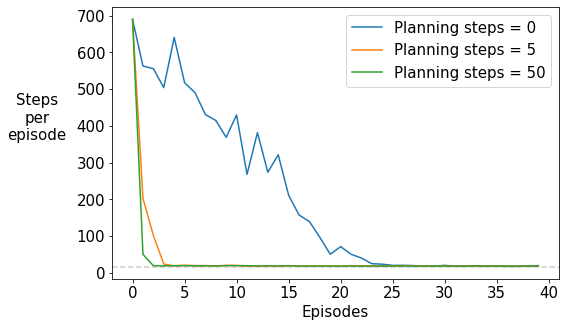

In [134]:
# ---------------
# Discussion Cell
# ---------------

# Experiment parameters
experiment_parameters = {
    "num_runs" : 30,                     # The number of times we run the experiment
    "num_episodes" : 40,                 # The number of episodes per experiment
}

# Environment parameters
environment_parameters = { 
    "discount": 0.95,
}

# Agent parameters
agent_parameters = {  
    "num_states" : 54,
    "num_actions" : 4, 
    "epsilon": 0.1, 
    "step_size" : 0.125,
    "planning_steps" : [0, 5, 50]       # The list of planning_steps we want to try
}

current_env = ShortcutMazeEnvironment   # The environment
current_agent = DynaQAgent              # The agent

dataq = run_experiment(current_env, current_agent, environment_parameters, agent_parameters, experiment_parameters)
plot_steps_per_episode(dataq)   

What do you notice?

As the number of planning steps increases, the number of episodes taken to reach the goal decreases rapidly. Remember that the RNG seed was set the same for all the three values of planning steps, resulting in the same number of steps taken to reach the goal in the first episode. Thereafter, the performance improves. The slowest improvement is when there are $n=0$ planning steps, i.e., for the non-planning Q-learning agent, even though the step size parameter was optimized for it. Note that the grey dotted line shows the minimum number of steps required to reach the goal state under the optimal greedy policy.

---


### Experiment(s): Dyna-Q agent in the _changing_ maze environment 

Great! Now let us see how Dyna-Q performs on the version of the maze in which a shorter path opens up after 3000 steps. The rest of the transition and reward dynamics remain the same. 

<img src="./images/shortcut_env_after.png" alt="environment" width="800"/>

Before you proceed, take a moment to think about what you expect to see. Will Dyna-Q find the new, shorter path to the goal? If so, why? If not, why not?

In [135]:
# ---------------
# Discussion Cell
# ---------------

def run_experiment_with_state_visitations(env, agent, env_parameters, agent_parameters, exp_parameters, result_file_name):

    # Experiment settings
    num_runs = exp_parameters['num_runs']
    num_max_steps = exp_parameters['num_max_steps']
    planning_steps_all = agent_parameters['planning_steps']

    env_info = {"change_at_n" : env_parameters["change_at_n"]}                     
    agent_info = {"num_states" : agent_parameters["num_states"],  
                  "num_actions" : agent_parameters["num_actions"],
                  "epsilon": agent_parameters["epsilon"], 
                  "discount": env_parameters["discount"],
                  "step_size" : agent_parameters["step_size"]}

    state_visits_before_change = np.zeros((len(planning_steps_all), num_runs, 54))  # For saving the number of
    state_visits_after_change = np.zeros((len(planning_steps_all), num_runs, 54))   #     state-visitations 
    cum_reward_all = np.zeros((len(planning_steps_all), num_runs, num_max_steps))   # For saving the cumulative reward
    log_data = {'planning_steps_all' : planning_steps_all}

    for idx, planning_steps in enumerate(planning_steps_all):

        print('Planning steps : ', planning_steps)
        os.system('sleep 1')          # to prevent tqdm printing out-of-order before the above print()
        agent_info["planning_steps"] = planning_steps  # We pass the agent the information it needs. 

        for run in tqdm(range(num_runs)):

            agent_info['random_seed'] = run
            agent_info['planning_random_seed'] = run

            rl_glue = RLGlue(env, agent)  # Creates a new RLGlue experiment with the env and agent we chose above
            rl_glue.rl_init(agent_info, env_info) # We pass RLGlue what it needs to initialize the agent and environment

            num_steps = 0
            cum_reward = 0

            while num_steps < num_max_steps-1 :

                state, _ = rl_glue.rl_start()  # We start the experiment. We'll be collecting the 
                is_terminal = False            # state-visitation counts to visiualize the learned policy
                if num_steps < env_parameters["change_at_n"]: 
                    state_visits_before_change[idx][run][state] += 1
                else:
                    state_visits_after_change[idx][run][state] += 1

                while not is_terminal and num_steps < num_max_steps-1 :
                    reward, state, action, is_terminal = rl_glue.rl_step()  
                    num_steps += 1
                    cum_reward += reward
                    cum_reward_all[idx][run][num_steps] = cum_reward
                    if num_steps < env_parameters["change_at_n"]:
                        state_visits_before_change[idx][run][state] += 1
                    else:
                        state_visits_after_change[idx][run][state] += 1

    log_data['state_visits_before'] = state_visits_before_change
    log_data['state_visits_after'] = state_visits_after_change
    log_data['cum_reward_all'] = cum_reward_all
    
    return log_data

def plot_cumulative_reward(data_all, item_key, y_key, y_axis_label, legend_prefix, title):
    data_y_all = data_all[y_key]
    items = data_all[item_key]

    for i, item in enumerate(items):
        plt.plot(np.mean(data_y_all[i], axis=0), label=legend_prefix+str(item))

    plt.axvline(x=3000, linestyle='--', color='grey', alpha=0.4)
    plt.xlabel('Timesteps')
    plt.ylabel(y_axis_label, rotation=0, labelpad=60)
    plt.legend(loc='upper left')
    plt.title(title)
    plt.show()

Did you notice that the environment changes after a fixed number of _steps_ and not episodes? 

This is because the environment is separate from the agent, and the environment changes irrespective of the length of each episode (i.e., the number of environmental interactions per episode) that the agent perceives. And hence we are now plotting the data per step or interaction of the agent and the environment, in order to comfortably see the differences in the behaviours of the agents before and after the environment changes.  

Okay, now we will first plot the cumulative reward obtained by the agent per interaction with the environment, averaged over 10 runs of the experiment on this changing world. 

Planning steps :  5


100%|██████████| 10/10 [00:10<00:00,  1.10s/it]


Planning steps :  10


100%|██████████| 10/10 [00:15<00:00,  1.57s/it]


Planning steps :  50


100%|██████████| 10/10 [01:07<00:00,  6.73s/it]


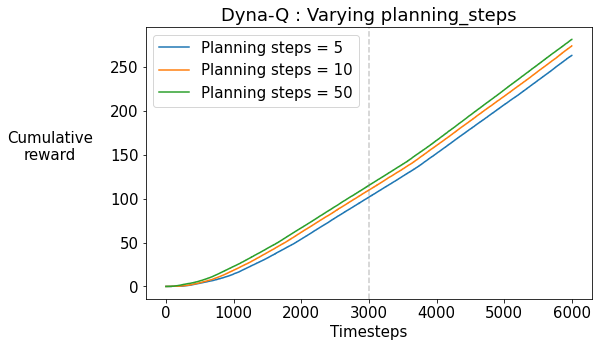

In [136]:
# ---------------
# Discussion Cell
# ---------------

# Experiment parameters
experiment_parameters = {
    "num_runs" : 10,                     # The number of times we run the experiment
    "num_max_steps" : 6000,              # The number of steps per experiment
}

# Environment parameters
environment_parameters = { 
    "discount": 0.95,
    "change_at_n": 3000
}

# Agent parameters
agent_parameters = {  
    "num_states" : 54,
    "num_actions" : 4, 
    "epsilon": 0.1, 
    "step_size" : 0.125,
    "planning_steps" : [5, 10, 50]      # The list of planning_steps we want to try
}

current_env = ShortcutMazeEnvironment   # The environment
current_agent = DynaQAgent              # The agent

dataq = run_experiment_with_state_visitations(current_env, current_agent, environment_parameters, agent_parameters, experiment_parameters, "Dyna-Q_shortcut_steps")    
plot_cumulative_reward(dataq, 'planning_steps_all', 'cum_reward_all', 'Cumulative\nreward', 'Planning steps = ', 'Dyna-Q : Varying planning_steps')

We observe that the slope of the curves is almost constant. If the agent had discovered the shortcut and begun using it, we would expect to see an increase in the slope of the curves towards the later stages of training. This is because the agent can get to the goal state faster and get the positive reward. Note that the timestep at which the shortcut opens up is marked by the grey dotted line.

Note that this trend is constant across the increasing number of planning steps.

Now let's check the heatmap of the state visitations of the agent with `planning_steps=10` during training, before and after the shortcut opens up after 3000 timesteps.

In [137]:
# ---------------
# Discussion Cell
# ---------------

def plot_state_visitations(data, plot_titles, idx):
    data_keys = ["state_visits_before", "state_visits_after"]
    positions = [211,212]
    titles = plot_titles
    wall_ends = [None,-1]

    for i in range(2):

        state_visits = data[data_keys[i]][idx]
        average_state_visits = np.mean(state_visits, axis=0)
        grid_state_visits = np.rot90(average_state_visits.reshape((6,9)).T)
        grid_state_visits[2,1:wall_ends[i]] = np.nan # walls
        #print(average_state_visits.reshape((6,9)))
        plt.subplot(positions[i])
        plt.pcolormesh(grid_state_visits, edgecolors='gray', linewidth=1, cmap='viridis')
        plt.text(3+0.5, 0+0.5, 'S', horizontalalignment='center', verticalalignment='center')
        plt.text(8+0.5, 5+0.5, 'G', horizontalalignment='center', verticalalignment='center')
        plt.title(titles[i])
        plt.axis('off')
        cm = plt.get_cmap()
        cm.set_bad('gray')

    plt.subplots_adjust(bottom=0.0, right=0.7, top=1.0)
    cax = plt.axes([1., 0.0, 0.075, 1.])
    cbar = plt.colorbar(cax=cax)
    plt.show()

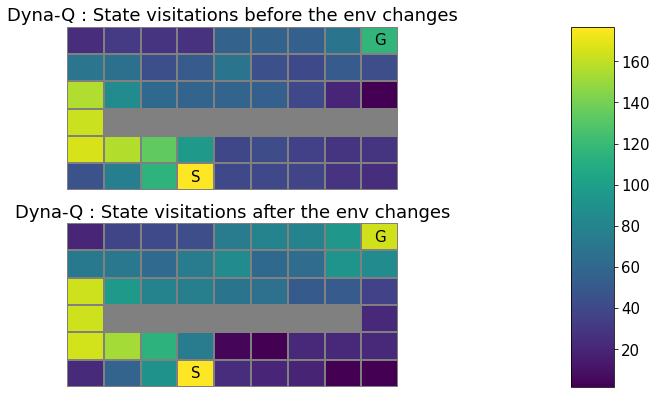

In [138]:
# Do not modify this cell!

plot_state_visitations(dataq, ['Dyna-Q : State visitations before the env changes', 'Dyna-Q : State visitations after the env changes'], 1)

What do you observe?

The state visitation map looks almost the same before and after the shortcut opens. This means that the Dyna-Q agent hasn't quite discovered and started exploiting the new shortcut.

Now let's try increasing the exploration parameter $\epsilon$ to see if it helps the Dyna-Q agent discover the shortcut. 

In [139]:
# ---------------
# Discussion Cell
# ---------------

def run_experiment_only_cumulative_reward(env, agent, env_parameters, agent_parameters, exp_parameters):

    # Experiment settings
    num_runs = exp_parameters['num_runs']
    num_max_steps = exp_parameters['num_max_steps']
    epsilons = agent_parameters['epsilons']

    env_info = {"change_at_n" : env_parameters["change_at_n"]}                     
    agent_info = {"num_states" : agent_parameters["num_states"],  
                  "num_actions" : agent_parameters["num_actions"],
                  "planning_steps": agent_parameters["planning_steps"], 
                  "discount": env_parameters["discount"],
                  "step_size" : agent_parameters["step_size"]}

    log_data = {'epsilons' : epsilons} 
    cum_reward_all = np.zeros((len(epsilons), num_runs, num_max_steps))

    for eps_idx, epsilon in enumerate(epsilons):

        print('Agent : Dyna-Q, epsilon : %f' % epsilon)
        os.system('sleep 1')          # to prevent tqdm printing out-of-order before the above print()
        agent_info["epsilon"] = epsilon

        for run in tqdm(range(num_runs)):

            agent_info['random_seed'] = run
            agent_info['planning_random_seed'] = run

            rl_glue = RLGlue(env, agent)  # Creates a new RLGlue experiment with the env and agent we chose above
            rl_glue.rl_init(agent_info, env_info) # We pass RLGlue what it needs to initialize the agent and environment

            num_steps = 0
            cum_reward = 0

            while num_steps < num_max_steps-1 :

                rl_glue.rl_start()  # We start the experiment
                is_terminal = False

                while not is_terminal and num_steps < num_max_steps-1 :
                    reward, _, action, is_terminal = rl_glue.rl_step()  # The environment and agent take a step and return
                    # the reward, and action taken.
                    num_steps += 1
                    cum_reward += reward
                    cum_reward_all[eps_idx][run][num_steps] = cum_reward

    log_data['cum_reward_all'] = cum_reward_all
    return log_data

Agent : Dyna-Q, epsilon : 0.100000


100%|██████████| 30/30 [00:48<00:00,  1.61s/it]


Agent : Dyna-Q, epsilon : 0.200000


100%|██████████| 30/30 [00:48<00:00,  1.63s/it]


Agent : Dyna-Q, epsilon : 0.400000


100%|██████████| 30/30 [00:47<00:00,  1.57s/it]


Agent : Dyna-Q, epsilon : 0.800000


100%|██████████| 30/30 [00:48<00:00,  1.63s/it]


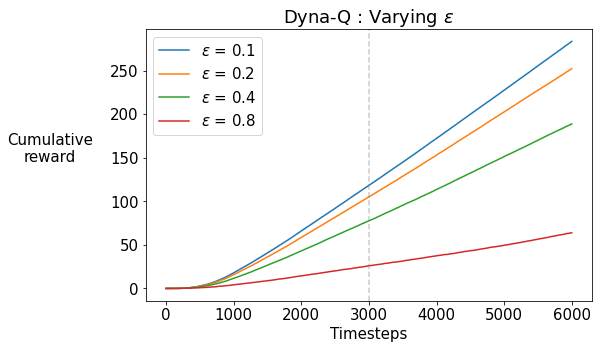

In [140]:
# ---------------
# Discussion Cell
# ---------------

# Experiment parameters
experiment_parameters = {
    "num_runs" : 30,                     # The number of times we run the experiment
    "num_max_steps" : 6000,              # The number of steps per experiment
}

# Environment parameters
environment_parameters = { 
    "discount": 0.95,
    "change_at_n": 3000
}

# Agent parameters
agent_parameters = {  
    "num_states" : 54,
    "num_actions" : 4, 
    "step_size" : 0.125,
    "planning_steps" : 10,
    "epsilons": [0.1, 0.2, 0.4, 0.8]    # The list of epsilons we want to try
}

current_env = ShortcutMazeEnvironment   # The environment
current_agent = DynaQAgent              # The agent

data = run_experiment_only_cumulative_reward(current_env, current_agent, environment_parameters, agent_parameters, experiment_parameters)
plot_cumulative_reward(data, 'epsilons', 'cum_reward_all', 'Cumulative\nreward', r'$\epsilon$ = ', r'Dyna-Q : Varying $\epsilon$')

What do you observe?

Increasing the exploration via the $\epsilon$-greedy strategy does not seem to be helping. In fact, the agent's cumulative reward decreases because it is spending more and more time trying out the exploratory actions.

Can we do better...? 

## Section 2: Dyna-Q+

The motivation behind Dyna-Q+ is to give a bonus reward for actions that haven't been tried for a long time, since there is a greater chance that the dynamics for that actions might have changed.

In particular, if the modeled reward for a transition is $r$, and the transition has not been tried in $\tau(s,a)$ time steps, then planning updates are done as if that transition produced a reward of $r + \kappa \sqrt{ \tau(s,a)}$, for some small $\kappa$. 

Let's implement that!

Based on your `DynaQAgent`, create a new class `DynaQPlusAgent` to implement the aforementioned exploration heuristic. Additionally :
1. actions that had never been tried before from a state should now be allowed to be considered in the planning step,
2. and the initial model for such actions is that they lead back to the same state with a reward of zero.

At this point, you might want to refer to the video lectures and [Section 8.3](http://www.incompleteideas.net/book/RLbook2018.pdf#page=188) of the RL textbook for a refresher on Dyna-Q+.

As usual, let's break this down in pieces and do it one-by-one.

First of all, check out the `agent_init` method below. In particular, pay attention to the attributes which are new to `DynaQPlusAgent`â€“ state-visitation counts $\tau$ and the scaling parameter $\kappa$ â€“ because you shall be using them later. 

In [141]:
# ---------------
# Discussion Cell
# ---------------

class DynaQPlusAgent(BaseAgent):
    
    def agent_init(self, agent_info):
        """Setup for the agent called when the experiment first starts.

        Args:
            agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
            {
                num_states (int): The number of states,
                num_actions (int): The number of actions,
                epsilon (float): The parameter for epsilon-greedy exploration,
                step_size (float): The step-size,
                discount (float): The discount factor,
                planning_steps (int): The number of planning steps per environmental interaction
                kappa (float): The scaling factor for the reward bonus

                random_seed (int): the seed for the RNG used in epsilon-greedy
                planning_random_seed (int): the seed for the RNG used in the planner
            }
        """

        # First, we get the relevant information from agent_info 
        # Note: we use np.random.RandomState(seed) to set the two different RNGs
        # for the planner and the rest of the code
        try:
            self.num_states = agent_info["num_states"]
            self.num_actions = agent_info["num_actions"]
        except:
            print("You need to pass both 'num_states' and 'num_actions' \
                   in agent_info to initialize the action-value table")
        self.gamma = agent_info.get("discount", 0.95)
        self.step_size = agent_info.get("step_size", 0.1)
        self.epsilon = agent_info.get("epsilon", 0.1)
        self.planning_steps = agent_info.get("planning_steps", 10)
        self.kappa = agent_info.get("kappa", 0.001)

        self.rand_generator = np.random.RandomState(agent_info.get('random_seed', 42))
        self.planning_rand_generator = np.random.RandomState(agent_info.get('planning_random_seed', 42))

        # Next, we initialize the attributes required by the agent, e.g., q_values, model, tau, etc.
        # The visitation-counts can be stored as a table as well, like the action values 
        self.q_values = np.zeros((self.num_states, self.num_actions))
        self.tau = np.zeros((self.num_states, self.num_actions))
        self.actions = list(range(self.num_actions))
        self.past_action = -1
        self.past_state = -1
        self.model = {}

Now first up, implement the `update_model` method. Note that this is different from Dyna-Q in the aforementioned way.


In [142]:
%%add_to DynaQPlusAgent

# -----------
# Graded Cell
# -----------

def update_model(self, past_state, past_action, state, reward):
    """updates the model 

    Args:
        past_state  (int): s
        past_action (int): a
        state       (int): s'
        reward      (int): r
    Returns:
        Nothing
    """

    # Recall that when adding a state-action to the model, if the agent is visiting the state
    #    for the first time, then the remaining actions need to be added to the model as well
    #    with zero reward and a transition into itself.
    #
    # Note: do *not* update the visitation-counts here. We will do that in `agent_step`.
    #
    # (3 lines)

    if past_state not in self.model:        
        self.model[past_state] = {past_action : (state, reward)}                
        # ----------------
        # your code here       
        # ----------------
        remaining_actions = set(self.actions) - {past_action}
        [self.add_action(a, past_state, past_action) for a in remaining_actions]
    else:
        self.model[past_state][past_action] = (state, reward)
        
def add_action(self, action, past_state, past_action):
    self.model[past_state][action] = (past_state, 0)
    

In [143]:
# The contents of the cell will be tested by the autograder.
# If they do not pass here, they will not pass there.

actions = []
agent_info = {"num_actions": 4, 
              "num_states": 3, 
              "epsilon": 0.1, 
              "step_size": 0.1, 
              "discount": 1.0, 
              "random_seed": 0,
              "planning_random_seed": 0}

agent = DynaQPlusAgent()
agent.agent_init(agent_info)

agent.update_model(0,2,0,1)
agent.update_model(2,0,1,1)
agent.update_model(0,3,1,2)
agent.tau[0][0] += 1

expected_model = {
    0: {
        0: (0, 0),
        1: (0, 0),
        2: (0, 1),
        3: (1, 2),
    },
    2: {
        0: (1, 1),
        1: (2, 0),
        2: (2, 0),
        3: (2, 0),
    },
}
print(agent.model)
assert agent.model == expected_model

{0: {2: (0, 1), 0: (0, 0), 1: (0, 0), 3: (1, 2)}, 2: {0: (1, 1), 1: (2, 0), 2: (2, 0), 3: (2, 0)}}


### Test `update_model()`

In [144]:
# -----------
# Tested Cell
# -----------
# The contents of the cell will be tested by the autograder.
# If they do not pass here, they will not pass there.

actions = []
agent_info = {"num_actions": 4, 
              "num_states": 3, 
              "epsilon": 0.1, 
              "step_size": 0.1, 
              "discount": 1.0, 
              "random_seed": 0,
              "planning_random_seed": 0}

agent = DynaQPlusAgent()
agent.agent_init(agent_info)

agent.update_model(0,2,0,1)
agent.update_model(2,0,1,1)
agent.update_model(0,3,1,2)
agent.tau[0][0] += 1

expected_model = {
    0: {
        0: (0, 0),
        1: (0, 0),
        2: (0, 1),
        3: (1, 2),
    },
    2: {
        0: (1, 1),
        1: (2, 0),
        2: (2, 0),
        3: (2, 0),
    },
}
assert agent.model == expected_model

Next, you will implement the `planning_step()` method. This will be very similar to the one you implemented in `DynaQAgent`, but here you will be adding the exploration bonus to the reward in the simulated transition.

In [145]:
%%add_to DynaQPlusAgent

# -----------
# Graded Cell
# -----------

def planning_step(self):
    """performs planning, i.e. indirect RL.

    Args:
        None
    Returns:
        Nothing
    """
    
    # The indirect RL step:
    # - Choose a state and action from the set of experiences that are stored in the model. (~2 lines)
    # - Query the model with this state-action pair for the predicted next state and reward.(~1 line)
    # - **Add the bonus to the reward** (~1 line)
    # - Update the action values with this simulated experience.                            (2~4 lines)
    # - Repeat for the required number of planning steps.
    #
    # Note that the update equation is different for terminal and non-terminal transitions. 
    # To differentiate between a terminal and a non-terminal next state, assume that the model stores
    # the terminal state as a dummy state like -1
    #
    # Important: remember you have a random number generator 'planning_rand_generator' as 
    #     a part of the class which you need to use as self.planning_rand_generator.choice()
    #     For the sake of reproducibility and grading, *do not* use anything else like 
    #     np.random.choice() for performing search control.

    # ----------------
    # your code here
    for n in range(0,self.planning_steps):
        state = self.planning_rand_generator.choice(list(self.model.keys()))
        action = self.planning_rand_generator.choice(list(self.model[state].keys()))
        next_state, reward = self.model[state][action]
        
        reward = reward + self.kappa * np.sqrt(self.tau[(state,action)])
        
        q = self.q_values[state, action]
        
        if next_state == -1:
            max_action = 0
        else:
            max_action = np.max(self.q_values[next_state, :])
        
        self.q_values[state, action] = q + self.step_size * (reward + self.gamma * max_action - q)
    # ----------------

In [146]:
# Do not modify this cell!

## Test code for planning_step() ##

actions = []
agent_info = {"num_actions": 4, 
              "num_states": 3, 
              "epsilon": 0.1, 
              "step_size": 0.1, 
              "discount": 1.0, 
              "kappa": 0.001,
              "planning_steps": 4,
              "random_seed": 0,
              "planning_random_seed": 1}

agent = DynaQPlusAgent()
agent.agent_init(agent_info)

agent.update_model(0,1,-1,1)
agent.tau += 1
print(agent.tau)
agent.tau[0][1] = 0

agent.update_model(0,2,1,1)
agent.tau += 1
agent.tau[0][2] = 0

agent.update_model(2,0,1,1)
agent.tau += 1
agent.tau[2][0] = 0
print(agent.model)
agent.planning_step()

expected_model = {
    0: {
        1: (-1, 1), 
        0: (0, 0), 
        2: (1, 1), 
        3: (0, 0),
    }, 
    2: {
        0: (1, 1), 
        1: (2, 0), 
        2: (2, 0), 
        3: (2, 0),
    },
}
print(agent.model)
print(expected_model)
#assert agent.model == expected_model

expected_values = np.array([
    [0, 0.10014142, 0, 0],
    [0, 0, 0, 0],
    [0, 0.00036373, 0, 0.00017321],
])
print(agent.q_values)
assert np.allclose(agent.q_values, expected_values)

[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
{0: {1: (-1, 1), 0: (0, 0), 2: (1, 1), 3: (0, 0)}, 2: {0: (1, 1), 1: (2, 0), 2: (2, 0), 3: (2, 0)}}
{0: {1: (-1, 1), 0: (0, 0), 2: (1, 1), 3: (0, 0)}, 2: {0: (1, 1), 1: (2, 0), 2: (2, 0), 3: (2, 0)}}
{0: {1: (-1, 1), 0: (0, 0), 2: (1, 1), 3: (0, 0)}, 2: {0: (1, 1), 1: (2, 0), 2: (2, 0), 3: (2, 0)}}
[[0.         0.10014142 0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.00036373 0.         0.00017321]]


### Test `planning_step()`

In [147]:
# Do not modify this cell!

## Test code for planning_step() ##

actions = []
agent_info = {"num_actions": 4, 
              "num_states": 3, 
              "epsilon": 0.1, 
              "step_size": 0.1, 
              "discount": 1.0, 
              "kappa": 0.001,
              "planning_steps": 4,
              "random_seed": 0,
              "planning_random_seed": 1}

agent = DynaQPlusAgent()
agent.agent_init(agent_info)

agent.update_model(0,1,-1,1)
agent.tau += 1
agent.tau[0][1] = 0

agent.update_model(0,2,1,1)
agent.tau += 1
agent.tau[0][2] = 0

agent.update_model(2,0,1,1)
agent.tau += 1
agent.tau[2][0] = 0

agent.planning_step()

expected_model = {
    0: {
        1: (-1, 1), 
        0: (0, 0), 
        2: (1, 1), 
        3: (0, 0),
    }, 
    2: {
        0: (1, 1), 
        1: (2, 0), 
        2: (2, 0), 
        3: (2, 0),
    },
}
assert agent.model == expected_model

expected_values = np.array([
    [0, 0.10014142, 0, 0],
    [0, 0, 0, 0],
    [0, 0.00036373, 0, 0.00017321],
])
assert np.allclose(agent.q_values, expected_values)

Again, before you move on to implement the rest of the agent methods, here are the couple of helper functions that you've used in the previous assessments for choosing an action using an $\epsilon$-greedy policy.

In [148]:
%%add_to DynaQPlusAgent

# ---------------
# Discussion Cell
# ---------------

def argmax(self, q_values):
    """argmax with random tie-breaking
    Args:
        q_values (Numpy array): the array of action values
    Returns:
        action (int): an action with the highest value
    """
    top = float("-inf")
    ties = []

    for i in range(len(q_values)):
        if q_values[i] > top:
            top = q_values[i]
            ties = []

        if q_values[i] == top:
            ties.append(i)

    return self.rand_generator.choice(ties)

def choose_action_egreedy(self, state):
    """returns an action using an epsilon-greedy policy w.r.t. the current action-value function.

    Important: assume you have a random number generator 'rand_generator' as a part of the class
                which you can use as self.rand_generator.choice() or self.rand_generator.rand()

    Args:
        state (List): coordinates of the agent (two elements)
    Returns:
        The action taken w.r.t. the aforementioned epsilon-greedy policy
    """

    if self.rand_generator.rand() < self.epsilon:
        action = self.rand_generator.choice(self.actions)
    else:
        values = self.q_values[state]
        action = self.argmax(values)

    return action

Now implement the rest of the agent-related methods, namely `agent_start`, `agent_step`, and `agent_end`. Again, these will be very similar to the ones in the `DynaQAgent`, but you will have to think of a way to update the counts since the last visit.

In [149]:
%%add_to DynaQPlusAgent

# -----------
# Graded Cell
# -----------
    
def agent_start(self, state):
    """The first method called when the experiment starts, called after
    the environment starts.
    Args:
        state (Numpy array): the state from the
            environment's env_start function.
    Returns:
        (int) The first action the agent takes.
    """
    
    # given the state, select the action using self.choose_action_egreedy(), 
    # and save current state and action (~2 lines)
    ### self.past_state = ?
    ### self.past_action = ?
    # Note that the last-visit counts are not updated here.
    
    # ----------------
    # your code here
    self.past_state = state
    self.past_action = self.choose_action_egreedy(state)
    # ----------------
    
    return self.past_action

def agent_step(self, reward, state):
    """A step taken by the agent.
    Args:
        reward (float): the reward received for taking the last action taken
        state (Numpy array): the state from the
            environment's step based on where the agent ended up after the
            last step
    Returns:
        (int) The action the agent is taking.
    """  
    
    # Update the last-visited counts (~2 lines)
    # - Direct-RL step (1~3 lines)
    # - Model Update step (~1 line)
    # - `planning_step` (~1 line)
    # - Action Selection step (~1 line)
    # Save the current state and action before returning the action to be performed. (~2 lines)
    
    # ----------------
    # your code here
    agent.tau += 1
    agent.tau[self.past_state][self.past_action] = 0
    action = self.choose_action_egreedy(state)
    q = self.q_values[self.past_state, self.past_action]
    max_action = np.max(self.q_values[state, :])    
    self.q_values[self.past_state, self.past_action] = q + self.step_size * (reward + self.gamma * max_action - q)
    self.update_model(self.past_state, self.past_action, state, reward)
    self.planning_step()
    self.past_state = state
    self.past_action = action
    # ----------------
    
    return self.past_action

def agent_end(self, reward):
    """Called when the agent terminates.
    Args:
        reward (float): the reward the agent received for entering the
            terminal state.
    """
    # Again, add the same components you added in agent_step to augment Dyna-Q into Dyna-Q+
    
    # ----------------
    # your code here
    agent.tau += 1
    agent.tau[self.past_state][self.past_action] = 0
    q = self.q_values[self.past_state, self.past_action]
    self.q_values[self.past_state, self.past_action] = q + self.step_size * (reward - q)
    self.update_model(self.past_state, self.past_action, -1, reward)
    self.planning_step()
    # ----------------

### Test `agent_start()`, `agent_step()`, and `agent_end()`

In [150]:
# -----------
# Tested Cell
# -----------
# The contents of the cell will be tested by the autograder.
# If they do not pass here, they will not pass there.

agent_info = {"num_actions": 4, 
              "num_states": 3, 
              "epsilon": 0.1, 
              "step_size": 0.1, 
              "discount": 1.0,
              "kappa": 0.001,
              "random_seed": 0,
              "planning_steps": 4,
              "planning_random_seed": 0}

agent = DynaQPlusAgent()
agent.agent_init(agent_info)

action = agent.agent_start(0) # state
assert action == 1

assert np.allclose(agent.tau, 0)
assert np.allclose(agent.q_values, 0)
assert agent.model == {}

# ---------------
# test agent step
# ---------------

action = agent.agent_step(1, 2)
assert action == 3

action = agent.agent_step(0, 1)
assert action == 1

expected_tau = np.array([
    [2, 1, 2, 2],
    [2, 2, 2, 2],
    [2, 2, 2, 0],
])
assert np.all(agent.tau == expected_tau)

expected_values = np.array([
    [0.0191, 0.271, 0.0, 0.0191],
    [0, 0, 0, 0],
    [0, 0.000183847763, 0.000424264069, 0],
])
assert np.allclose(agent.q_values, expected_values)

expected_model = {
    0: {
        1: (2, 1), 
        0: (0, 0), 
        2: (0, 0), 
        3: (0, 0),
    }, 
    2: {
        3: (1, 0), 
        0: (2, 0), 
        1: (2, 0), 
        2: (2, 0),
    },
}
assert agent.model == expected_model

# --------------
# test agent end
# --------------
agent.agent_end(1)

expected_tau = np.array([
    [3, 2, 3, 3],
    [3, 0, 3, 3],
    [3, 3, 3, 1],
])
assert np.all(agent.tau == expected_tau)

expected_values = np.array([
    [0.0191, 0.344083848, 0, 0.0444632051],
    [0.0191732051, 0.19, 0, 0],
    [0, 0.000183847763, 0.000424264069, 0],
])
assert np.allclose(agent.q_values, expected_values)

expected_model = {0: {1: (2, 1), 0: (0, 0), 2: (0, 0), 3: (0, 0)}, 2: {3: (1, 0), 0: (2, 0), 1: (2, 0), 2: (2, 0)}, 1: {1: (-1, 1), 0: (1, 0), 2: (1, 0), 3: (1, 0)}}
assert agent.model == expected_model

### Experiment: Dyna-Q+ agent in the _changing_ environment

Okay, now we're ready to test our Dyna-Q+ agent on the Shortcut Maze. As usual, we will average the results over 30 independent runs of the experiment.

In [151]:
# ---------------
# Discussion Cell
# ---------------

# Experiment parameters
experiment_parameters = {
    "num_runs" : 30,                     # The number of times we run the experiment
    "num_max_steps" : 6000,              # The number of steps per experiment
}

# Environment parameters
environment_parameters = { 
    "discount": 0.95,
    "change_at_n": 3000
}

# Agent parameters
agent_parameters = {  
    "num_states" : 54,
    "num_actions" : 4, 
    "epsilon": 0.1, 
    "step_size" : 0.5,
    "planning_steps" : [50]      
}

current_env = ShortcutMazeEnvironment   # The environment
current_agent = DynaQPlusAgent          # The agent

data_qplus = run_experiment_with_state_visitations(current_env, current_agent, environment_parameters, agent_parameters, experiment_parameters, "Dyna-Q+")

Planning steps :  50


  0%|          | 0/30 [00:00<?, ?it/s]


IndexError: index 48 is out of bounds for axis 0 with size 3

Let's compare the Dyna-Q and Dyna-Q+ agents with `planning_steps=50` each.

In [ ]:
# ---------------
# Discussion Cell
# ---------------

def plot_cumulative_reward_comparison(data1, data2):

    cum_reward_q = data1['cum_reward_all'][2]
    cum_reward_qPlus = data2['cum_reward_all'][0]

    plt.plot(np.mean(cum_reward_qPlus, axis=0), label='Dyna-Q+')
    plt.plot(np.mean(cum_reward_q, axis=0), label='Dyna-Q')

    plt.axvline(x=3000, linestyle='--', color='grey', alpha=0.4)
    plt.xlabel('Timesteps')
    plt.ylabel('Cumulative\nreward', rotation=0, labelpad=60)
    plt.legend(loc='upper left')
    plt.title('Average performance of Dyna-Q and Dyna-Q+ agents in the Shortcut Maze\n')
    plt.show()

In [ ]:
# ---------------
# Discussion Cell
# ---------------

plot_cumulative_reward_comparison(dataq, data_qplus)

What do you observe? (For reference, your graph should look like [Figure 8.5 in Chapter 8](http://www.incompleteideas.net/book/RLbook2018.pdf#page=189) of the RL textbook)

The slope of the curve increases for the Dyna-Q+ curve shortly after the shortcut opens up after 3000 steps, which indicates that the rate of receiving the positive reward increases. This implies that the Dyna-Q+ agent finds the shorter path to the goal.

To verify this, let us plot the state-visitations of the Dyna-Q+ agent before and after the shortcut opens up.

In [ ]:
# ---------------
# Discussion Cell
# ---------------

plot_state_visitations(data_qplus, ['Dyna-Q+ : State visitations before the env changes', 'Dyna-Q+ : State visitations after the env changes'], 0)

What do you observe?

Before the shortcut opens up, like Dyna-Q, the Dyna-Q+ agent finds the sole, long path to the goal. But because the Dyna-Q+ agent keeps exploring, it succeeds in discovering the shortcut once it opens up, which leads to the goal faster. So the bonus reward heuristic is effective in helping the agent explore and find changes in the environment without degrading the performance. 

## Wrapping Up

Congratulations! You have:

1. implemented Dyna-Q, a model-based approach to RL;
2. implemented Dyna-Q+, a variant of Dyna-Q with an exploration bonus that encourages exploration; 
3. conducted scientific experiments to empirically validate the exploration/exploitation dilemma in the planning context on an environment that changes with time.

Some points to ponder about:
1. At what cost does Dyna-Q+ improve over Dyna-Q?
2. In general, what is the trade-off of using model-based methods like Dyna-Q over model-free methods like Q-learning?
